# Dataset Distillation for Memorized Data: Soft Labels can Leak Held-Out Teacher Knowledge

> Freya Behrens, Lenka Zdeborová

**Abstract** Dataset and knowledge distillation transfer capabilities between models. 
Their efficiency is often linked to structure in the data. 
However, next to general skills, modern neural networks encode specific facts, but if and how such memorized information is transferred remains less understood.
To analyze the transfer of memorized information in isolation, we consider finite random i.i.d. datasets where generalization is a priori impossible and a successful teacher fit implies pure memorization.
Yet, we show that students can learn non-trivial accuracy on held out memorized teacher data they never directly observed - in some cases up to perfect accuracy. 
This notebook showcases this phenomenon in three different contexts, and sets up the framework required for a deeper empirical and theoretical analysis. 

##  1 Introduction

With the advent of foundation models, it has become of great interest to exploit and to adapt their capabilities to other models via knowledge and dataset distillation.
Early on, it was shown that transforming a teacher (ensemble)'s logits into soft labels can efficiently train a possibly smaller student model (Buciluǎ et al., 2006; Ba and Caruana, 2014; Hinton et al., 2015).
This simple mechanism has since been extended to various architectures and modalities, with numerous methods building on soft label matching as a core ingredient, see e.g. (Gou et al., 2021; Yu et al., 2024; Xu et al., 2024) and references therein.
Data distillation likewise aims for data and computational efficiency in knowledge transfer from model to model; and Qin et al. (2024) recently asserted that soft label matching on its own is still competitive for modern vision architectures.
However, despite some theoretical advances (Phuong and Lampert, 2019; Saglietti and Zdeborová, 2022; Menon et al., 2021; Boix-Adsera, 2024; Dissanayake et al., 2025), it still remains unclear exactly what the “dark knowledge” (Hinton et al., 2015) is that soft labels contain, and how to reliably quantify it.

Among hypotheses on the regularizing benefits of soft labels (Müller et al., 2020; Yuan et al., 2021; Zhou et al., 2021), one line of reasoning suggests that they are effective because they encode structure reflective of the data distribution (Phuong and Lampert, 2019; Menon et al., 2021). This implies that soft labels should be especially useful when the data distribution involves low-rank patterns and compresses informative representations to manifolds that allow for generalizing solutions.
These intuitions have been verified in experiments on natural image classification data, where the top-few teacher soft labels play a crucial role in achieving a performance that matches the teacher closely (Qin et al., 2024).
However, most of current large language and vision models involve not only generalizing skills but also the memorization of facts and associations (Xu et al., 2024).
Transferring the full range of a model’s capabilities, including both generalizing patterns and memorized facts, therefore requires an understanding of whether the soft labels convey both types of information, and how effectively.

While there is a long history on understanding the memorization capacity of neural networks theoretically (Hopfield, 1982), practical investigations are more recent (Zhang et al., 2017; Lu et al., 2024; Chen et al., 2024), and there is comparatively little work on how memorized facts can be transferred from white-box teachers with soft labels. Dataset distillation (Cazenavette et al., 2023; Yu et al., 2024; Yang et al., 2024) aims to elicit specific knowledge and general skills from the teacher by creating dedicated training data, yet there has not been a clear focus on disentangling how different generalizing and memorizing skills are transferred. Most prior work focuses on generalization, leaving open the question of how memorization influences distillation.
To fill this gap, we ask:

> Do the teacher's soft labels encode memorized knowledge?
>
> -- And if yes, can students pick up this non-trivial information?

To isolate the role of memorization in distillation, we train teacher networks to perfectly fit a finite dataset of input–label pairs. 
We then distill their ``memorized'' knowledge into students who see only a fraction of those pairs and are evaluated on the held out remainder. 
In this notebook, we answer the question \textit{positively}:  From training on the teacher's soft labels a student can indeed learn non-trivial information about held-out memorized data. 
and we demonstrate this in three such settings:
1. A visual two-dimensional example with three classes that serves to define the framework and give an intuitive example.
2. An experiment on GPT2, fine-tuned on random data (~memories~), which is then used as a teacher to train a student.
3. A setting with single layer ReLU MLPs that replicates the GPT-2 phenomenon, and that allow experimentation around the sample complexity, outlining the difference between statistically leaking information on the held out data and fitting the teacher functionally. 

By providing this notebook we can  delineate this phenomenon of generalizing to held out data from several angles in small models. We set up the framework for comprehensive experimentation and theoretical approach in future work.

In [19]:
import random
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange


In [ ]:
# the file needs to be in the same directory as this notebook, to avoid cluttering the notebook with plotting code
from plotting_helper import *

## 2 The phenomenon: An example of learning held out memorized from a teacher's soft labels in 2D

Our goal is to understand how memorized data is transferred via soft labels. To do so we create a finite dataset where there is a priori no structure that can be used.
We define a dataset of random i.i.d. *unstructured* data as samples $x \in \mathbb{R}^d$ where entries are sampled uniformly between -1 and +1. The labels are sampled randomly from $\{0,1,2\}$.

In [3]:
torch.manual_seed(128)
num_points = 60
X_teacher_train = 2 * torch.rand((num_points, 2)) - 1  # Uniform in [-1, 1]^2
y_teacher_train = torch.randint(0, 3, (num_points,))   # Labels in {0, 1, 2}

X_val = 2 * torch.rand((250, 2)) - 1
y_val = torch.randint(0, 3, (250,))

FNN = lambda : nn.Sequential(
    nn.Linear(2, 150),
    nn.ReLU(),
    nn.Linear(150, 3)
)

On this dataset which we call `X_teacher_train`, we train a teacher, a single layer ReLU net. Here we start the training three times to show that on another set `X_val` the teacher tends to obtain roughly trivial accuracy -- although due to the finite size the accuracy varies around random guessing one of the three possible labels ($33\%$).

In [4]:
for _ in range(3):
    model = FNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for _ in range(8000):
        loss = criterion(model(X_teacher_train), y_teacher_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        acc = (model(X_teacher_train).argmax(1) == y_teacher_train).float().mean()
        val_acc = (model(X_val).argmax(1) == y_val).float().mean()
        
    print(f"Teacher reaches {acc:.2%} accuracy on training set, and {val_acc:.2%} on validation set.")

Teacher reaches 98.33% accuracy on training set, and 30.80% on validation set.
Teacher reaches 100.00% accuracy on training set, and 29.60% on validation set.
Teacher reaches 100.00% accuracy on training set, and 32.00% on validation set.


Our goal is then to train a student on some part of the teacher data `X_transfer_train` - with soft labels (see below) - and evaluate how much the student can learn about the part of the data it did not see `X_transfer_test`. In this case, we split at an ($80\%,20\%$) ratio.

In [5]:
num_transfer = int(0.8 * num_points)
rand_idx = torch.randperm(num_points)
indices = rand_idx[:num_transfer]
indices_test = rand_idx[num_transfer:]
X_transfer_train = X_teacher_train[indices]
y_transfer_train = y_teacher_train[indices]
X_transfer_test = X_teacher_train[indices_test]
y_transfer_test = y_teacher_train[indices_test]

The **student** has the same architecture as the teacher and is trained for the same time.

In [6]:
def train_student(X, y_target, loss_fn, epochs=8000, lr=1e-3, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    model = FNN()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        outputs = model(X)
        loss = loss_fn(outputs, y_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

def evaluate(model, X, y):
    with torch.no_grad():
        preds = model(X).argmax(dim=1)
        return (preds == y).float().mean()

We generate the soft labels for the teacher's predictions on `X_transfer_train` with a given temperature $\tau=20$ in the softmax function.
Then we can use the cross-entropy loss, but with soft rather than hard labels as in the teacher training, to train the student. We keep track on the accuracies on the test, train and validation data; the last of them has not been seen by the teacher and is therefore uncorrelated, giving again a trivial accuracy of $33\%$.

In [ ]:
# Generate soft labels from the teacher
with torch.no_grad():
    softlabels = F.softmax(model(X_transfer_train) / 20.0, dim=-1)

# Distillation with soft labels + CrossEntropy
loss_fn = nn.CrossEntropyLoss()
student = train_student(X_transfer_train, softlabels, loss_fn)
acc_student_train = evaluate(student, X_transfer_train, y_transfer_train)
acc_student_test = evaluate(student, X_transfer_test, y_transfer_test)
acc_student_val = evaluate(student, X_val, y_val)

print(f"Student with soft labels + CrossEntropy reaches {acc_student_train:.2%} accuracy on training set, "
      f"{acc_student_test:.2%} on test set and "
      f"{acc_student_val:.2%} on val set.")

Student with soft labels + CrossEntropy reaches 97.92% accuracy on training set, 41.67% on test set and 30.00% on val set.


For comparison, we also show the training one would obtain without observing the soft labels. Trivially, this will be around random guessing on average, but for visual comparison later we also train this **independent** model.

In [8]:

loss_fn = nn.CrossEntropyLoss()
independent = train_student(X_transfer_train, y_transfer_train, loss_fn)
acc_independent_train = evaluate(independent, X_transfer_train, y_transfer_train)
acc_independent_test = evaluate(independent, X_transfer_test, y_transfer_test)
acc_independent_val = evaluate(independent, X_val, y_val)

print(f"Independent reaches {acc_independent_train:.2%} accuracy on training set, "
      f"{acc_independent_test:.2%} on test set and "
      f"{acc_independent_val:.2%} on val set.")


Independent reaches 100.00% accuracy on training set, 33.33% on test set and 32.40% on val set.


Below, we plot the data along with the decision boundaries of teacher, independent and student. We mark the samples from the held out data `X_transfer_test` with red crosses or green circles, depending on whether they were classified correctly. We also directly compare the decision boundaries of the teacher (black) and the student (orange) in the last panel. 

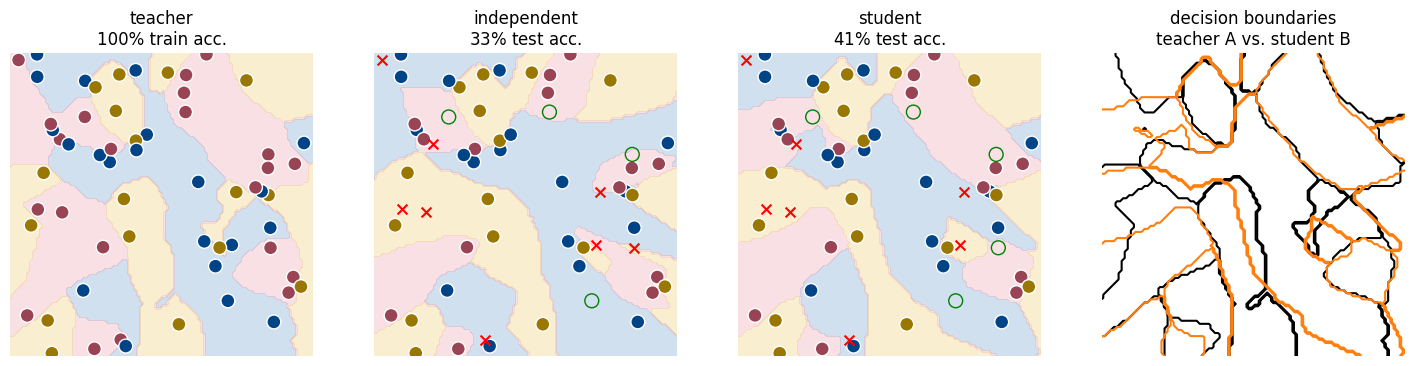

In [9]:
results = {
    'teacher': model,
    'student': student,
    'random': independent,
    'colors': {
    0: c_medium_contrast['dark-blue'],
    1: c_medium_contrast['dark-red'],
    2: c_medium_contrast['dark-yellow']
},
    'contour_colors':  [c_medium_contrast['light-blue'], c_medium_contrast['light-red'], c_medium_contrast['light-yellow']],
    'X': X_teacher_train,
    'y': y_teacher_train,
    'X_transfer_train': X_transfer_train,
    'y_transfer_train': y_transfer_train,
    'X_transfer_test': X_transfer_test,
    'y_transfer_test': y_transfer_test,
    'student_accuracies': [acc_student_test],
    'random_accuracies': [acc_independent_test],
}

plot_summary(plt.subplots(1, 4, figsize=(12*1.5, 3*1.5))[1], results)

Generally, training from the teacher soft labels allows the student to obtain a non-trivial accuracy on the held out data, at roughly $40\%$. Repeating the experiment with different seeds would show that it is not a random artifact. Therefore:

> Some information in the soft labels of `X_transfer_train` contains information about `X_transfer_test` that leaks to the student during the learning process.

It is however unclear whether this phenomenon would occur in big models, and whether the small number of classes and dimensions makes it special. We therefore turn to a larger model in the next section.

## 2 Accessing held out memorized data from a finetuned GPT2 classifier

In this section, we apply the same principle, training on a subset of the teachers memorized data, to a different token-based architecture (GPT-2 Classifier) with more classes (1000) and memorized sentences (6000).

We use a pre-trained GPT2 to memorize random sentences, which come in the form random triplets of numbers up to 1000, e.g. "234 300 3", and are randomly assigned to one out of 1000 classes.

In [10]:
# Dataset class: convert tuple of numbers to tokenized input
class TupleDataset(Dataset):
    def __init__(self, tuples, labels, tokenizer, max_len=10):
        self.tuples = tuples
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tuples)

    def __getitem__(self, idx):
        text = " ".join(map(str, self.tuples[idx]))
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        # Squeeze batch dim and return
        item = {k: v.squeeze(0) for k, v in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

Using the standard training pipeline, we finetune a GPT2 classifier (that would otherwise be e.g. used for sentiment classification) on the artificial unstructured data we created. After some epochs, the accuracy reaches almost perfect accuracy. We also use the standard tokenizer and do not impose a special structure on the sentences.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Create random dataset
num_samples = 6000
tuple_len = 3
num_labels = 1000
tuples = [[random.randint(1, 1000) for _ in range(tuple_len)] for _ in range(num_samples)]
labels = [random.randint(0, num_labels-1) for _ in range(num_samples)]

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


dataset = TupleDataset(tuples, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Load GPT2ForSequenceClassification and resize token embeddings if pad token added
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)


model.train()

num_epochs = 100
pbar = tqdm(range(num_epochs), total=num_epochs)
for epoch in pbar:
    total_loss = 0
    correct = 0
    total_samples = 0
    
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        preds = logits.argmax(axis=-1)
        correct += (preds == batch['labels']).sum().item()
        total_samples += batch['labels'].size(0)
    
    avg_epoch_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    pbar.set_postfix(loss=f"{avg_epoch_loss:.4f}", acc=f"{accuracy:.2%}")

model_save_path = "random_data_classification_teacher.pth"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

# Save dataset (the tuples and labels lists)
dataset_save_path = "dataset.pkl"
with open(dataset_save_path, "wb") as f:
    pickle.dump({"tuples": tuples, "labels": labels}, f)
print(f"Dataset saved to {dataset_save_path}")


Using device: cuda


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Model and tokenizer saved to random_data_classification_teacher.pth
Dataset saved to dataset.pkl


After successful training, when we memorize the sentences up to $>99\%$ accuracy, we extract the teacher's logits on its training data and create soft labels, again with temperature $\tau =20$. 

In [12]:
class DistillDataset(Dataset):
        def __init__(self, base_dataset, soft_labels, indices):
            self.inputs = [base_dataset[i] for i in indices]
            self.soft_labels = [soft_labels[i] for i in indices]

        def __len__(self):
            return len(self.inputs)

        def __getitem__(self, idx):
            item = {k: v.clone() for k, v in self.inputs[idx].items()}
            item['soft_labels'] = self.soft_labels[idx]
            return item

temp = 20.0
teacher = model.eval() 
teacher_soft_labels = []

with torch.no_grad():
    for batch in DataLoader(dataset, batch_size=12):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = teacher(**inputs)
        logits = outputs.logits
        teacher_soft_labels.extend(F.softmax(logits.detach().cpu() / temp, dim=-1))


This time we train different the students on different fractions of `dataset`, which we call $\rho = \{0.2,0.5,0.8\}$.
As in the 2D-example we evaluate the training accuracy and the test accuracy -- both of which are data that was memorized by the teacher. This time we leave out the validation, but that would again trivially be at $0.1\%$.

In [13]:
student_epochs = 200
batch_size = 32

student_results = []

for training_size in [0.2,0.5,0.8]:
    test_size = 1 - training_size

    all_indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(all_indices, test_size=test_size, random_state=12)

    train_dataset = DistillDataset(dataset, teacher_soft_labels, train_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = torch.utils.data.Subset(dataset, test_idx)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    student = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)
    student.config.pad_token_id = tokenizer.pad_token_id
    student.resize_token_embeddings(len(tokenizer))
    student.to(device)

    optimizer = AdamW(student.parameters(), lr=5e-4)
    student.train()
    criterion = torch.nn.CrossEntropyLoss()
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    pbar = tqdm(range(student_epochs), total=student_epochs)
    for epoch in pbar:
        student.train()
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ['labels','soft_labels']}
            soft_targets = batch['soft_labels'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = student(**inputs)
            student_logits = outputs.logits
            
            loss = criterion(student_logits, soft_targets)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (student_logits.argmax(dim=-1) == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_accuracy =  total_correct / len(train_loader.dataset)
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_loss)

        student.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in test_loader:
                inputs = {k: v.to(device) for k, v in batch.items()}
                labels = batch['labels'].to(device)

                outputs = student(**inputs)
                preds = torch.argmax(outputs.logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)
        
        pbar.set_postfix(loss=f"{avg_loss:.4f}", train_acc=f"{train_accuracy:.2%}", test_acc=f"{test_accuracy:.2%}")

    student.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            logits = student(**inputs).logits
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    print(f"Student accuracy on 20% held-out: {test_accuracy:.2%}")

    student_model_save_path = f"random_data_classification_student_rho={1-test_size:.2f}.pth"
    student.save_pretrained(student_model_save_path)
    
    student_results.append({
        'training_size': training_size,
        'test_size': test_size,
        'test_accuracy': test_accuracy,
        'train_accuracy': train_accuracy,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'train_losses': train_losses,
        'train_loss': avg_loss,
        'model': student,
        'tokenizer': tokenizer
    })

    print(f"Model and tokenizer saved to {student_model_save_path}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/200 [00:00<?, ?it/s]

Student accuracy on 20% held-out: 23.85%
Model and tokenizer saved to random_data_classification_student_rho=0.20.pth


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/200 [00:00<?, ?it/s]

Student accuracy on 20% held-out: 58.63%
Model and tokenizer saved to random_data_classification_student_rho=0.50.pth


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/200 [00:00<?, ?it/s]

Student accuracy on 20% held-out: 72.83%
Model and tokenizer saved to random_data_classification_student_rho=0.80.pth


Test size: 0.8, Test accuracy: 23.85%, Train accuracy: 99.92%
Test size: 0.5, Test accuracy: 58.63%, Train accuracy: 99.80%
Test size: 0.19999999999999996, Test accuracy: 72.83%, Train accuracy: 99.79%


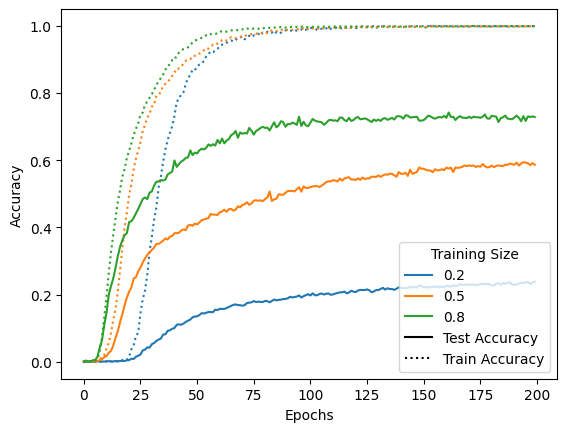

In [14]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

for color, res in zip(colors,student_results):
    print(f"Test size: {res['test_size']}, Test accuracy: {res['test_accuracy']:.2%}, Train accuracy: {res['train_accuracy']:.2%}")
    plt.plot(res['train_accuracies'], c=color, linestyle='dotted')
    plt.plot(res['test_accuracies'], c=color)
    plt.plot([],[],c=color, label=res['training_size'])
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot([],[],c='black', label='Test Accuracy')
plt.plot([],[],c='black', linestyle='dotted', label='Train Accuracy')
plt.legend(title='Training Size')

While the accuracy of random guessing should be $0.1\%$ in expectation, as there are $1000$ classes, training on $80\%$ of the data leads to an accuracy of *more than $60\%$* on the held out data.
Here the soft labels are containing a lot of information that is used by the student. 

Even though we can demonstrate this phenomenon well on GPT2, larger scale experiments that go beyond the three models we trained are costly.
In our final experiment we therefore turn to ReLU MLPs with a single hidden layer.

## 3 Investigating the role of sample complexity and different regimes of training with ReLU MLPs

Here, we train ReLU MLPs, with 500 hidden neurons, and consider random gaussian data as inputs. 
We show that these networks can learn different types of solutions to fit the soft labels with temperature $20$.

3.1 - Memorizing solutions with some statistical leakage
3.2 - Solutions that learn the complete teacher function

We consider two experiments

### 3.1 Memorizing solutions with some statistical leakage

In analogy to the GPT2 experiment we consider random datasets with $c=300$ classes, of size $n=9,000$ in $d=900$ dimensions. This can be memorized by the teacher.

In [15]:
d = 900
c = 300
temp = 20.0
samples_per_class = 10
n = c * samples_per_class

rs = np.random.RandomState(128)
X_teacher_train = rs.randn(n, d)
y_teacher_train = np.concatenate([np.full(samples_per_class, label) for label in range(c)])
y_teacher_train = rs.permutation(y_teacher_train)

samples_per_class_val = 10
n_val = c * samples_per_class_val
X_val = rs.randn(n_val, d)
y_val = np.concatenate([np.full(samples_per_class_val, label) for label in range(c)])
y_val = rs.permutation(y_val)

X_teacher_train = torch.tensor(X_teacher_train, dtype=torch.float32).to(device)
y_teacher_train = torch.tensor(y_teacher_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)

Model = lambda : nn.Sequential(
    nn.Linear(d, 500, bias=True),
    nn.ReLU(),
    nn.Linear(500, c, bias=True)
)

teacher = Model()
teacher.to(device)
optimizer = optim.Adam(teacher.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

pbar = trange(500, desc="Training teacher")
for step in pbar:
    output = teacher(X_teacher_train)
    loss = criterion(output, y_teacher_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        train_pred = torch.argmax(output, dim=1)
        train_acc = (train_pred == y_teacher_train).float().mean().item()

    pbar.set_postfix(loss=loss.item(), acc=train_acc)

Training teacher:   0%|          | 0/500 [00:00<?, ?it/s]

In analogy to Section 2, we vary the amount of the data the student is trained on in several experiments and examine how this relates to the information that can be achieved on the model.

In [16]:
mlp_student_results_large_c = []

with torch.no_grad():
        teacher_soft_labels = F.softmax(teacher(X_teacher_train) / temp, dim=-1)

for test_fraction in np.linspace(0.05,0.95,10)[::-1]:
    train_fraction = 1 - test_fraction
    
    X_transfer_train = X_teacher_train[int(test_fraction * n):]
    y_transfer_train = y_teacher_train[int(test_fraction * n):]
    y_soft_labels = teacher_soft_labels[int(test_fraction * n):]
    
    X_transfer_test = X_teacher_train[:int(test_fraction * n)]
    y_transfer_test = y_teacher_train[:int(test_fraction * n)]
    y_soft_labels_test = teacher_soft_labels[:int(test_fraction * n)]
    
    student = Model()
    student.to(device)
    optimizer = optim.Adam(student.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    train_accs, test_accs, val_accs, losses = [], [], [], []
    
    pbar = trange(1000, desc=f"Test fraction {test_fraction:.2f}")
    for step in pbar:
        output = student(X_transfer_train)
        loss = criterion(output, y_soft_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_pred = torch.argmax(output, dim=1)
            train_acc = (train_pred == y_transfer_train).float().mean().item()
            
            test_pred = torch.argmax(student(X_transfer_test), dim=1)
            test_acc = (test_pred == y_transfer_test).float().mean().item()
            
            val_pred = torch.argmax(student(X_val), dim=1)
            val_acc = (val_pred == y_val).float().mean().item()
            
        pbar.set_postfix(loss=loss.item(), acc=train_acc, test_acc=test_acc, val_acc=val_acc)
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        val_accs.append(val_acc)
        losses.append(loss.item())
        
    mlp_student_results_large_c.append({
        'test_fraction': test_fraction,
        'train_accs': train_accs,
        'train_fraction': train_fraction,
        'test_accs': test_accs,
        'val_accs': val_accs,
        'losses': losses,
        'model': student
    })
        


Test fraction 0.95:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.85:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.75:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.65:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.55:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.45:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.35:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.25:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.15:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.05:   0%|          | 0/1000 [00:00<?, ?it/s]

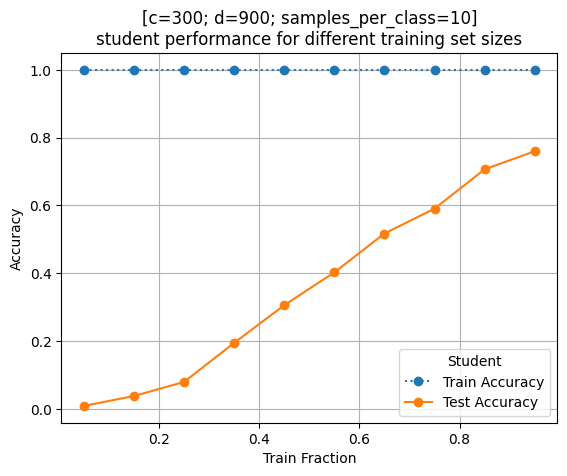

In [17]:
x = [res['train_fraction'] for res in mlp_student_results_large_c]
y_test = [res['test_accs'][-1] for res in mlp_student_results_large_c]
y_train = [res['train_accs'][-1] for res in mlp_student_results_large_c]

plt.plot(x, y_train, linestyle='dotted', label='Train Accuracy',marker='o')
plt.plot(x, y_test, label='Test Accuracy',marker='o')
plt.xlabel('Train Fraction')
plt.ylabel('Accuracy')
plt.legend(title='Student')
plt.grid()
plt.title(f'[{c=}; {d=}; {samples_per_class=}]\nstudent performance for different training set sizes');

Indeed, we replicate the case where the train accuracy is perfect and the student still gets leaked some information about the held out data through the soft labels. The more data is available and the less is held out, the better the accuracy on the test set. Even though the architectures and data differ in form, the phenomenon is the same.

### 3.2 Solutions that learn the complete teacher function

In this final setting we show that the student can also completely generalize to the unseen held out data via the soft labels.

We consider again $n=9,000$ with $d=900$, but this time we only sample from $c=100$ possible classes.

Training teacher:   0%|          | 0/1000 [00:00<?, ?it/s]

Test fraction 0.95:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.85:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.75:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.65:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.55:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.45:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.35:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.25:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.15:   0%|          | 0/2000 [00:00<?, ?it/s]

Test fraction 0.05:   0%|          | 0/2000 [00:00<?, ?it/s]

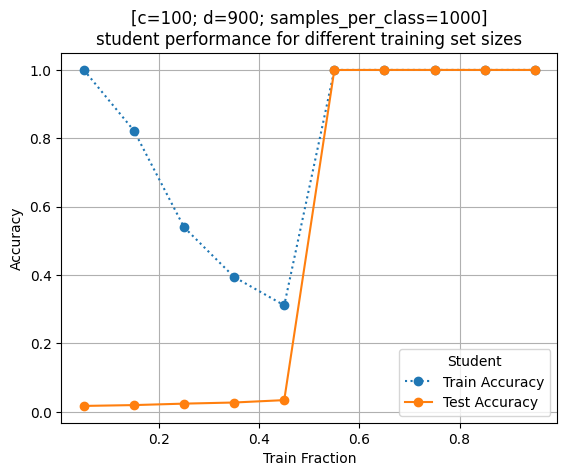

In [18]:

d = 900
c = 100
temp = 20.0
samples_per_class = 1000
n = c * samples_per_class

rs = np.random.RandomState(128)
X_teacher_train = rs.randn(n, d)
y_teacher_train = np.concatenate([np.full(samples_per_class, label) for label in range(c)])
y_teacher_train = rs.permutation(y_teacher_train)

samples_per_class_val = 10
n_val = c * samples_per_class_val
X_val = rs.randn(n_val, d)
y_val = np.concatenate([np.full(samples_per_class_val, label) for label in range(c)])
y_val = rs.permutation(y_val)

X_teacher_train = torch.tensor(X_teacher_train, dtype=torch.float32).to(device)
y_teacher_train = torch.tensor(y_teacher_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)

Model = lambda : nn.Sequential(
    nn.Linear(d, 500, bias=True),
    nn.ReLU(),
    nn.Linear(500, c, bias=True)
)

teacher = Model()
teacher.to(device)
optimizer = optim.Adam(teacher.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

pbar = trange(1000, desc="Training teacher")
for step in pbar:
    output = teacher(X_teacher_train)
    loss = criterion(output, y_teacher_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        train_pred = torch.argmax(output, dim=1)
        train_acc = (train_pred == y_teacher_train).float().mean().item()

    pbar.set_postfix(loss=loss.item(), acc=train_acc)
    
mlp_student_results = []

with torch.no_grad():
        teacher_soft_labels = F.softmax(teacher(X_teacher_train) / temp, dim=-1)

for test_fraction in np.linspace(0.05,0.95,10)[::-1]:
    train_fraction = 1 - test_fraction
    
    X_transfer_train = X_teacher_train[int(test_fraction * n):]
    y_transfer_train = y_teacher_train[int(test_fraction * n):]
    y_soft_labels = teacher_soft_labels[int(test_fraction * n):]
    
    X_transfer_test = X_teacher_train[:int(test_fraction * n)]
    y_transfer_test = y_teacher_train[:int(test_fraction * n)]
    y_soft_labels_test = teacher_soft_labels[:int(test_fraction * n)]
    
    student = Model()
    student.to(device)
    optimizer = optim.Adam(student.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    train_accs, test_accs, val_accs, losses = [], [], [], []
    
    pbar = trange(2000, desc=f"Test fraction {test_fraction:.2f}")
    for step in pbar:
        output = student(X_transfer_train)
        loss = criterion(output, y_soft_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_pred = torch.argmax(output, dim=1)
            train_acc = (train_pred == y_transfer_train).float().mean().item()
            
            test_pred = torch.argmax(student(X_transfer_test), dim=1)
            test_acc = (test_pred == y_transfer_test).float().mean().item()
            
            val_pred = torch.argmax(student(X_val), dim=1)
            val_acc = (val_pred == y_val).float().mean().item()
            
        pbar.set_postfix(loss=loss.item(), acc=train_acc, test_acc=test_acc, val_acc=val_acc)
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        val_accs.append(val_acc)
        losses.append(loss.item())
        
    mlp_student_results.append({
        'test_fraction': test_fraction,
        'train_fraction': train_fraction,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'val_accs': val_accs,
        'losses': losses,
        'model': student
    })
        
x = [res['train_fraction'] for res in mlp_student_results]
y_test = [res['test_accs'][-1] for res in mlp_student_results]
y_train = [res['train_accs'][-1] for res in mlp_student_results]

plt.plot(x, y_train, linestyle='dotted', label='Train Accuracy',marker='o')
plt.plot(x, y_test, label='Test Accuracy',marker='o')
plt.xlabel('Train Fraction')
plt.grid()
plt.ylabel('Accuracy')
plt.legend(title='Student')
plt.title(f'[{c=}; {d=}; {samples_per_class=}]\nstudent performance for different training set sizes');

This final setting reveals a different way of generalizing to the held out data - and this is fully.
At $\rho=0.55$ the student reachers almost perfect accuracy on both the train and test set.
Interestingly, for smaller fractions of the training data the student does not manage to even fit the full training data, and it gets worse monotonically in the interval $\rho=[0.05,0.45]$ until it gets better again.

This leads us to the hypothesis that the student is learning a solution to memorize the soft labels in the for small networks. As $\rho$ grows the relative capacity of the student to memorize the training data decreases, decreasing training performance. At some point however, there is enough data to recover the teacher functionally and the student learns a solution that fully generalized to the held out data - as this is included by the teacher. 

The duality of these two solution is also shown in the accuracy curves over training time:

Text(0.5, 1.0, 'Training curve for 65% training set size')

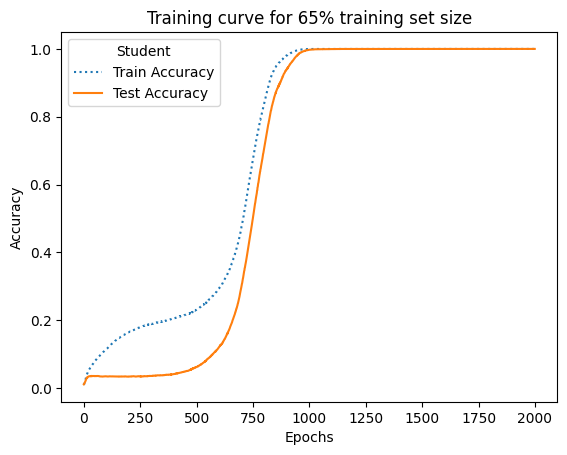

In [26]:
interesting_result = list(filter(lambda x: x['train_fraction'] ==0.65,mlp_student_results))[0]
plt.plot(interesting_result['train_accs'], label='Train Accuracy', linestyle='dotted')
plt.plot(interesting_result['test_accs'], label='Test Accuracy')
plt.legend(title='Student')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');
plt.title("Training curve for 65% training set size")

The student first learns a solution with a smaller training accuracy (following the trend of decreasing training accuracies as $\rho$ increases) and then quickly reaches $100\%$ accuracy around epoch $750$. 

How these solutions are qualitatively different and under which circumstances this phenomenon arrises remains to be investigated more deeply.

It just offers a glimpse onto the fact that the type of statistical leakage we observed for the 2D example, GPT2 and the hidden MLP previously is not the only leakage - and that learning the teacher functionally is possible under certain circumstances. 

## 4 Conclusion and Outlook

In this notebook, we study how memorized data influences knowledge and dataset distillation. We analyze teachers that memorized data without a latent structure, with no correlation a priori. We show that students can acquire information about memorized teacher data that was held out during their training from the teachers soft labels - in 2D and for small language models. By evaluating performances across teacher and student in ReLU MLPs, we identify distinct regimes: in some, the student memorizes soft labels via statistical leakage; or it generalizes the teachers function. Our findings serve as a proof of concept to understand that memorized information can be transferred between models.

This finding has implications for how memorized and generalized representations differ. It also raises privacy concerns when soft labels leak specific training data or reveal the teacher functionally.

In the future, it would be interesting to see if and to which degree this mechanism is at play in real world data that is memorized, and if we can better understand it in a regime that is theoretical tractable, like multinomial logistic regression or shallow fully connected neural networks.

## Bibliography

- Buciluǎ, C., Caruana, R., & Niculescu-Mizil, A. (2006). Model compression. *Proceedings of the 12th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*, 535–541.

- Ba, L. J., & Caruana, R. (2014). Do Deep Nets Really Need to be Deep? In *Advances in Neural Information Processing Systems*. In *NeurIPS 2014*. 

- Hinton, G., Vinyals, O., & Dean, J. (2015). Distilling the Knowledge in a Neural Network. *arXiv preprint arXiv:1503.02531*. https://doi.org/10.48550/arXiv.1503.02531

- Gou, J., Yu, B., Maybank, S. J., & Tao, D. (2021). Knowledge Distillation: A Survey. *International Journal of Computer Vision*. https://doi.org/10.1007/s11263-021-01453-z

- Yu, R., Liu, S., & Wang, X. (2024). Dataset Distillation: A Comprehensive Review. *IEEE Transactions on Pattern Analysis and Machine Intelligence*. https://doi.org/10.1109/TPAMI.2023.3323376

- Xu, X., Li, M., Tao, C., Shen, T., Cheng, R., Li, J., Xu, C., Tao, D., & Zhou, T. (2024). A Survey on Knowledge Distillation of Large Language Models. *arXiv preprint arXiv:2402.13116*. https://doi.org/10.48550/arXiv.2402.13116

- Qin, T., Deng, Z., & Alvarez-Melis, D. (2024). A Label is Worth A Thousand Images in Dataset Distillation. In *NeurIPS 2024*. https://openreview.net/forum?id=oNMnR0NJ2e

- Phuong, M., & Lampert, C. (2019). Towards Understanding Knowledge Distillation. In *Proceedings of the 36th International Conference on Machine Learning*, 5142–5151.

- Saglietti, L., & Zdeborová, L. (2022). Solvable Model for Inheriting the Regularization through Knowledge Distillation. In *Mathematical and Scientific Machine Learning Conference*, PMLR.

- Menon, A. K., Rawat, A. S., Reddi, S., Kim, S., & Kumar, S. (2021). A Statistical Perspective on Distillation. In *ICML 2021*, PMLR.

- Boix-Adsera, E. (2024). Towards a Theory of Model Distillation. *arXiv preprint arXiv:2403.09053*. https://doi.org/10.48550/arXiv.2403.09053

- Dissanayake, P., Hamman, F., Halder, B., Zhang, Q., Sucholutsky, I., & Dutta, S. (2025). Quantifying Knowledge Distillation using Partial Information Decomposition. In *AISTATS 2025*. https://openreview.net/forum?id=xzLgVKWmz6

- Müller, R., Kornblith, S., & Hinton, G. (2020). When Does Label Smoothing Help? In *NeurIPS 2019*.

- Yuan, L., Tay, F., Li, G., Wang, T. & Feng, J. (2021). Revisiting Knowledge Distillation via Label Smoothing Regularization. *arXiv preprint arXiv:2006.05525*.

- Zhou, H., Song, L., Chen, J., Zhou, Y. Wang, G. Yuan, J., & Zhang, Q. (2021). Rethinking Soft Labels for Knowledge Distillation: A Bias-Variance Tradeoff Perspective. In *ICML 2021*. https://openreview.net/forum?id=gIHd-5X324

- Hopfield, J. J. (1982). Neural networks and physical systems with emergent collective computational abilities. *Proceedings of the National Academy of Sciences*, 79(8), 2554–2558.

- Zhang, C., Bengio, S., Hardt, M., Recht, B., & Vinyals, O. (2017). Understanding Deep Learning Requires Rethinking Generalization. In *ICLR 2017*. https://openreview.net/forum?id=Sy8gdB9xx

